In [1]:
import numpy as np
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
from matplotlib import cm
import torch
from torch.optim.lr_scheduler import StepLR
import albumentations as A
from pathSeg.ml.hovernet import HoVerNet, loss_hovernet, post_process_batch_hovernet
from pathSeg.ml.utils import dice_score
from pathSeg.utils import plot_segmentation
import pytorch_model_summary as tms
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as transforms
import scipy.io
from glob import glob
from PIL import Image   
from loguru import logger
from torchvision.transforms import ToTensor
import cv2
import os
import random
print(f"GPUs used:\t{torch.cuda.device_count()}")
device = torch.device("cuda:4")
print(f"Device:\t\t{device}")

GPUs used:	8
Device:		cuda:4


In [2]:
params={'image_size':512,
        'lr':1e-4,
        'beta1':0.5,
        'beta2':0.999,
        'batch_size':1,
        'epochs':1000,
        'n_classes':None,
        'data_path':'../../data/NIA/STNT/',}

tf = ToTensor()

In [3]:
def compute_hv_map(mask):
    assert (
        mask.ndim == 2
    ), f"Input mask has shape {mask.shape}. Expecting a mask with 2 dimensions (H, W)"

    out = np.zeros((2, mask.shape[0], mask.shape[1]))
    # each individual nucleus is indexed with a different number
    inst_list = list(np.unique(mask))

    try:
        inst_list.remove(0)  # 0 is background
    # TODO: change to specific exception
    except Exception:
        logger.warning(
            "No pixels with 0 label. This means that there are no background pixels. This may indicate a problem. Ignore this warning if this is expected/intended."
        )

    for inst_id in inst_list:
        # get the mask for the nucleus
        inst_map = mask == inst_id
        inst_map = inst_map.astype(np.uint8)
        contours, _ = cv2.findContours(
            inst_map, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_NONE
        )

        # get center of mass coords
        mom = cv2.moments(contours[0])
        com_x = mom["m10"] / (mom["m00"] + 1e-6)
        com_y = mom["m01"] / (mom["m00"] + 1e-6)
        inst_com = (int(com_y), int(com_x))

        inst_x_range = np.arange(1, inst_map.shape[1] + 1)
        inst_y_range = np.arange(1, inst_map.shape[0] + 1)
        # shifting center of pixels grid to instance center of mass
        inst_x_range -= inst_com[1]
        inst_y_range -= inst_com[0]

        inst_x, inst_y = np.meshgrid(inst_x_range, inst_y_range)

        # remove coord outside of instance
        inst_x[inst_map == 0] = 0
        inst_y[inst_map == 0] = 0
        inst_x = inst_x.astype("float32")
        inst_y = inst_y.astype("float32")

        # normalize min into -1 scale
        if np.min(inst_x) < 0:
            inst_x[inst_x < 0] /= -np.amin(inst_x[inst_x < 0])
        if np.min(inst_y) < 0:
            inst_y[inst_y < 0] /= -np.amin(inst_y[inst_y < 0])
        # normalize max into +1 scale
        if np.max(inst_x) > 0:
            inst_x[inst_x > 0] /= np.amax(inst_x[inst_x > 0])
        if np.max(inst_y) > 0:
            inst_y[inst_y > 0] /= np.amax(inst_y[inst_y > 0])
        
        # add to output mask
        # this works assuming background is 0, and each pixel is assigned to only one nucleus.
        out[0, :, :] += inst_x
        out[1, :, :] += inst_y
    return out



class CustomDataset(Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self,parmas, images,file_list):
        
        self.images = images
        self.args=parmas
        self.file_list=file_list
        
    def trans(self,image,mask,hv_mask):
        if random.random() > 0.5:
            transform = transforms.RandomHorizontalFlip(1)
            image = transform(image)
            mask = transform(mask)
            hv_mask = transform(hv_mask)
            
        if random.random() > 0.5:
            transform = transforms.RandomVerticalFlip(1)
            image = transform(image)
            mask = transform(mask)
            hv_mask = transform(hv_mask)
            
        return image,mask,hv_mask
    
    def __getitem__(self, index):
        image=self.images[index]
        fileName=self.file_list[index]
        x = random.randint(0, image.shape[1] - self.args['image_size'])
        y = random.randint(0, image.shape[2] - self.args['image_size'])
        image = image[:,y:y+self.args['image_size'], x:x+self.args['image_size']]
        return image,fileName
    
    def __len__(self):
        return len(self.images)

image_list=glob(params['data_path']+'*.jpeg')[:200]

test_images=torch.zeros((len(image_list),3,1024,1024))
for i in tqdm(range(len(image_list))):
    test_images[i]=tf(Image.open(image_list[i]).convert('RGB'))

    

test_dataset=CustomDataset(params,test_images,image_list)
test_dataloader=DataLoader(test_dataset,batch_size=params['batch_size'],shuffle=True)

100%|██████████| 200/200 [00:08<00:00, 23.73it/s]


In [4]:
hovernet = HoVerNet(n_classes=params['n_classes']).to(device)

opt = torch.optim.Adam(hovernet.parameters(), lr = params['lr'], betas=(params['beta1'], params['beta2']))
# learning rate scheduler to reduce LR by factor of 10 each 25 epochs
scheduler = StepLR(opt, step_size=25, gamma=0.1)
checkpoint = torch.load("../../model/pathSeg/hovernet_binary_best_perf.pt")
hovernet.load_state_dict(checkpoint)
tms.summary(hovernet, torch.zeros(params['batch_size'],3, params['image_size'], params['image_size']).to(device),print_summary=True)


-----------------------------------------------------------------------------------------------------------------------------------------
         Layer (type)                                                                       Output Shape         Param #     Tr. Param #
   _HoVerNetEncoder-1     [1, 256, 512, 512], [1, 512, 256, 256], [1, 1024, 128, 128], [1, 1024, 64, 64]      25,590,912      25,590,912
   _HoverNetDecoder-2                                                                  [1, 64, 512, 512]      10,638,848      10,638,848
             Conv2d-3                                                                   [1, 2, 512, 512]             130             130
   _HoverNetDecoder-4                                                                  [1, 64, 512, 512]      10,638,848      10,638,848
             Conv2d-5                                                                   [1, 2, 512, 512]             130             130
Total params: 46,868,868
Trainable param

'-----------------------------------------------------------------------------------------------------------------------------------------\n         Layer (type)                                                                       Output Shape         Param #     Tr. Param #\n=========================================================================================================================================\n   _HoVerNetEncoder-1     [1, 256, 512, 512], [1, 512, 256, 256], [1, 1024, 128, 128], [1, 1024, 64, 64]      25,590,912      25,590,912\n   _HoverNetDecoder-2                                                                  [1, 64, 512, 512]      10,638,848      10,638,848\n             Conv2d-3                                                                   [1, 2, 512, 512]             130             130\n   _HoverNetDecoder-4                                                                  [1, 64, 512, 512]      10,638,848      10,638,848\n             Conv2d-5          

In [5]:
hovernet.eval()

ims = None
mask_truth = None
mask_pred = None
tissue_types = []
name_list=[]
with torch.no_grad():
    for i, data in tqdm(enumerate(test_dataloader)):
        # send the data to the GPU
        images = data[0].float().to(device)
        file_name=os.path.basename(data[1][0])
        name_list.append(file_name)
        # pass thru network to get predictions
        outputs = hovernet(images)
        preds_detection = post_process_batch_hovernet(outputs, n_classes=params['n_classes'])
        
        if i == 0:
            ims = data[0].numpy()
            mask_pred = preds_detection

        else:
            ims = np.concatenate([ims, data[0].numpy()], axis=0)
            mask_pred = np.concatenate([mask_pred, preds_detection], axis=0)

200it [00:31,  6.40it/s]


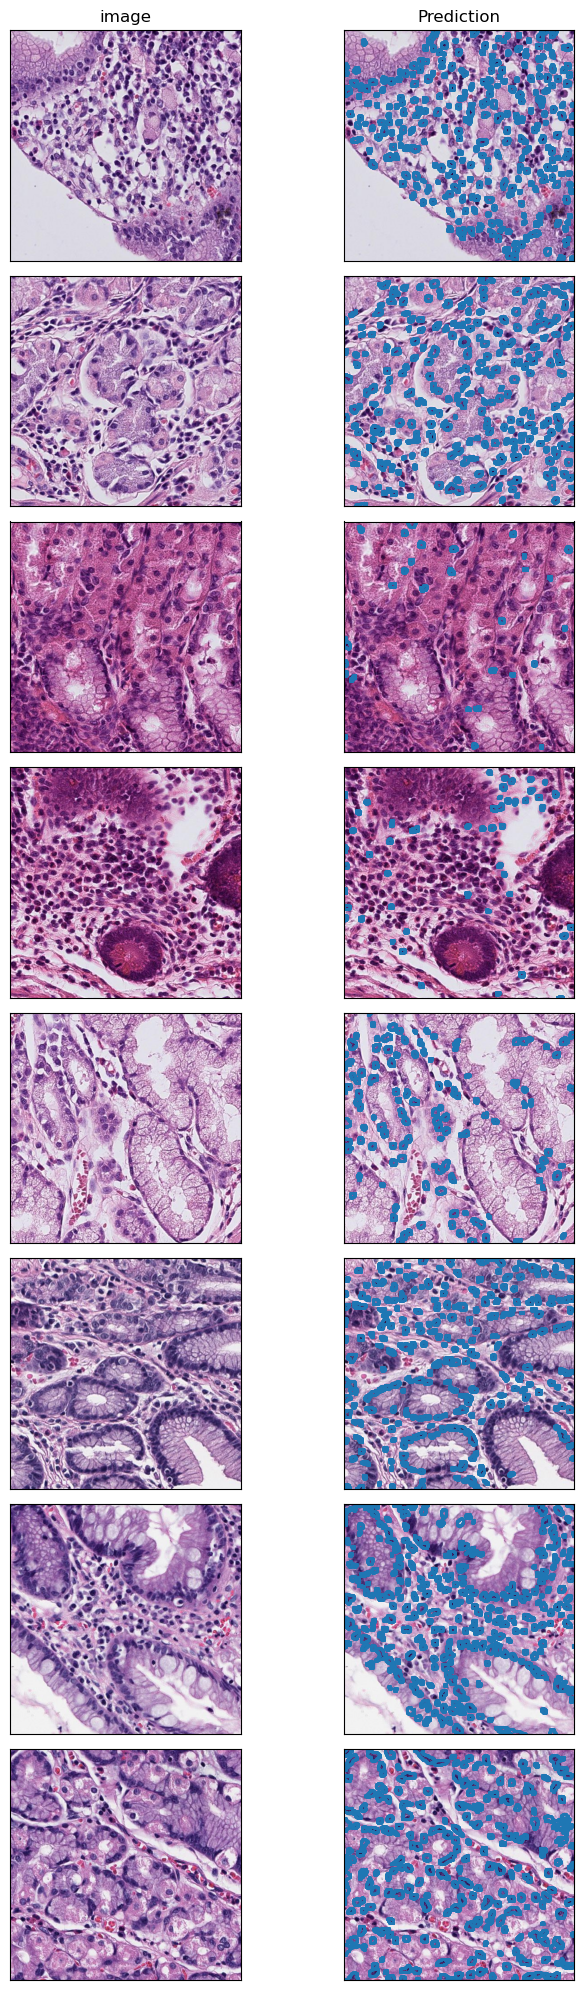

In [9]:
ims1 = np.moveaxis(ims, 1, 3)
n = 8
mask_pred1=mask_pred[:,np.newaxis,:,:] 
ix = np.random.choice(np.arange(200), size = n)
fig, ax = plt.subplots(nrows = n, ncols = 2, figsize = (8, 2.5*n))
for i, index in enumerate(ix):
    ax[i, 0].imshow(ims1[index, ...])
    ax[i, 1].imshow(ims1[index, ...])
    plot_segmentation(ax = ax[i, 1], masks = mask_pred1[index, ...])
        
for a in ax.ravel(): 
    a.get_xaxis().set_ticks([])
    a.get_yaxis().set_ticks([])
ax[0, 0].set_title("image")
ax[0, 1].set_title("Prediction")
plt.tight_layout()
plt.show()

In [10]:
name_list[ix[0]]

'NIA6_R_STNT_STOP-YN-01344-S-TP-02_52_29.jpeg'

In [8]:
ims.shape

(200, 3, 512, 512)